In [1]:
import copy
import json
import os
from pathlib import Path

import subprocess

from loguru import logger
from getpass import getpass
from semantic_router.encoders import HuggingFaceEncoder
from semantic_router.splitters import RollingWindowSplitter
#from semantic_router.utils.logger import logger


encoder = HuggingFaceEncoder(
    name="BAAI/bge-m3",
    device="cpu" #cuda 
)

# the following lines are meant to be used with GPU

from mineru.cli.common import convert_pdf_bytes_to_bytes_by_pypdfium2, prepare_env, read_fn
from mineru.data.data_reader_writer import FileBasedDataWriter
from mineru.utils.draw_bbox import draw_layout_bbox, draw_span_bbox
from mineru.utils.enum_class import MakeMode
from mineru.backend.vlm.vlm_analyze import doc_analyze as vlm_doc_analyze
from mineru.backend.pipeline.pipeline_analyze import doc_analyze as pipeline_doc_analyze
from mineru.backend.pipeline.pipeline_middle_json_mkcontent import union_make as pipeline_union_make
from mineru.backend.pipeline.model_json_to_middle_json import result_to_middle_json as pipeline_result_to_middle_json
from mineru.backend.vlm.vlm_middle_json_mkcontent import union_make as vlm_union_make
from mineru.utils.models_download_utils import auto_download_and_get_model_root_path


splitter_pdf = RollingWindowSplitter(
    encoder=encoder,
    dynamic_threshold=True,
    min_split_tokens=150,
    max_split_tokens=300,
    window_size=5,
    plot_splits=True,  # set this to true to visualize chunking
    enable_statistics=True  # to print chunking stats
)

splitter_txt = RollingWindowSplitter(
    encoder=encoder,
    dynamic_threshold=True,
    min_split_tokens=100,
    max_split_tokens=200,
    window_size=2,
    plot_splits=False,  # set this to true to visualize chunking
    enable_statistics=False  # to print chunking stats
)

#to be used with GPU


def do_parse(
    output_dir,  # Output directory for storing parsing results
    pdf_file_names: list[str],  # List of PDF file names to be parsed
    pdf_bytes_list: list[bytes],  # List of PDF bytes to be parsed
    p_lang_list: list[str],  # List of languages for each PDF, default is 'ch' (Chinese)
    backend="pipeline",  # The backend for parsing PDF, default is 'pipeline'
    parse_method="auto",  # The method for parsing PDF, default is 'auto'
    formula_enable=True,  # Enable formula parsing
    table_enable=True,  # Enable table parsing
    server_url=None,  # Server URL for vlm-sglang-client backend
    f_draw_layout_bbox=False,  # Whether to draw layout bounding boxes
    f_draw_span_bbox=False,  # Whether to draw span bounding boxes
    f_dump_md=True,  # Whether to dump markdown files
    f_dump_middle_json=False,  # Whether to dump middle JSON files
    f_dump_model_output=False,  # Whether to dump model output files
    f_dump_orig_pdf=False,  # Whether to dump original PDF files
    f_dump_content_list=False,  # Whether to dump content list files
    f_make_md_mode=MakeMode.MM_MD,  # The mode for making markdown content, default is MM_MD
    start_page_id=0,  # Start page ID for parsing, default is 0
    end_page_id=None,  # End page ID for parsing, default is None (parse all pages until the end of the document)
):
    if backend == "pipeline":
        for idx, pdf_bytes in enumerate(pdf_bytes_list):
            new_pdf_bytes = convert_pdf_bytes_to_bytes_by_pypdfium2(pdf_bytes, start_page_id, end_page_id)
            pdf_bytes_list[idx] = new_pdf_bytes
        infer_results, all_image_lists, all_pdf_docs, lang_list, ocr_enabled_list = pipeline_doc_analyze(pdf_bytes_list, p_lang_list, parse_method=parse_method, formula_enable=formula_enable,table_enable=table_enable)
        for idx, model_list in enumerate(infer_results):
            model_json = copy.deepcopy(model_list)
            pdf_file_name = pdf_file_names[idx]
            local_image_dir, local_md_dir = prepare_env(output_dir, pdf_file_name, parse_method)
            image_writer, md_writer = FileBasedDataWriter(local_image_dir), FileBasedDataWriter(local_md_dir)
            images_list = all_image_lists[idx]
            pdf_doc = all_pdf_docs[idx]
            _lang = lang_list[idx]
            _ocr_enable = ocr_enabled_list[idx]
            middle_json = pipeline_result_to_middle_json(model_list, images_list, pdf_doc, image_writer, _lang, _ocr_enable, formula_enable)
            pdf_info = middle_json["pdf_info"]
            pdf_bytes = pdf_bytes_list[idx]
            if f_draw_layout_bbox:
                draw_layout_bbox(pdf_info, pdf_bytes, local_md_dir, f"{pdf_file_name}_layout.pdf")
            if f_draw_span_bbox:
                draw_span_bbox(pdf_info, pdf_bytes, local_md_dir, f"{pdf_file_name}_span.pdf")
            if f_dump_orig_pdf:
                md_writer.write(
                    f"{pdf_file_name}_origin.pdf",
                    pdf_bytes,
                )
            if f_dump_md:
                image_dir = str(os.path.basename(local_image_dir))
                md_content_str = pipeline_union_make(pdf_info, f_make_md_mode, image_dir)
                
                md_writer.write_string(
                    f"{pdf_file_name}.md",
                    md_content_str,
                )
                return md_content_str
            if f_dump_content_list:
                image_dir = str(os.path.basename(local_image_dir))
                content_list = pipeline_union_make(pdf_info, MakeMode.CONTENT_LIST, image_dir)
                md_writer.write_string(
                    f"{pdf_file_name}_content_list.json",
                    json.dumps(content_list, ensure_ascii=False, indent=4),
                )
            if f_dump_middle_json:
                md_writer.write_string(
                    f"{pdf_file_name}_middle.json",
                    json.dumps(middle_json, ensure_ascii=False, indent=4),
                )
            if f_dump_model_output:
                md_writer.write_string(
                    f"{pdf_file_name}_model.json",
                    json.dumps(model_json, ensure_ascii=False, indent=4),
                )
            logger.info(f"local output dir is {local_md_dir}")
    else:
        print("Backend not found")

        
def parse_doc(
        path_list: list[Path],
        output_dir,
        lang="en",
        backend="pipeline",
        method="auto",
        server_url=None,
        start_page_id=0,
        end_page_id=None
):
    try:
        file_name_list = []
        pdf_bytes_list = []
        lang_list = []
        for path in path_list:
            file_name = str(Path(path).stem)
            pdf_bytes = read_fn(path)
            file_name_list.append(file_name)
            pdf_bytes_list.append(pdf_bytes)
            lang_list.append(lang)
        do_parse_result = do_parse(
            output_dir=output_dir,
            pdf_file_names=file_name_list,
            pdf_bytes_list=pdf_bytes_list,
            p_lang_list=lang_list,
            backend=backend,
            parse_method=method,
            server_url=server_url,
            start_page_id=start_page_id,
            end_page_id=end_page_id
        )
        return do_parse_result
    except Exception as e:
        logger.exception(e)
        
        
def get_pdf_chunks(doc_path_list, output_dir, lenguage="en"):
    parsed = parse_doc(doc_path_list, output_dir, lang=lenguage, backend="pipeline")
    splits = splitter_pdf([parsed])
    chunks = []
    for i in range(len(splits)):
        x = " ".join(splits[i].docs)
        chunks.append(x)
    return chunks


def get_txt_chunks(txt):
    splits = splitter_txt([txt])
    chunks = []
    for i in range(len(splits)):
        chunks.append(splits[i].docs)

    return chunks



def get_doc_chunks(doc_path, output_dir, lenguage="en"):
    #"en"
    
    os.makedirs(output_dir, exist_ok=True)

    # Convert DOCX to PDF using LibreOffice
    "/home/peyzaguirre/notebooks/dev_chunking_system/table.pdf"
    pdf_filename = os.path.splitext(os.path.basename(doc_path))[0] + ".pdf"
    output_pdf_path = os.path.join(output_dir, pdf_filename)

    subprocess.run([
        "soffice", "--headless", "--convert-to", "pdf",
        "--outdir", output_dir, doc_path
    ], check=True)
    
    parsed = parse_doc([output_pdf_path], output_dir, lang=lenguage, backend="pipeline")
    splits = splitter_pdf([parsed])
    
    chunks = []
    for i in range(len(splits)):
        chunks.append(splits[i].docs)
    return chunks


/home/peyzaguirre/notebooks/dev_chunking_system/semantic_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-29 10:53:50.898 | WARNING  | mineru.backend.vlm.predictor:<module>:35 - sglang is not installed. If you are not using sglang, you can ignore this warning.


## SEMANTIC CHUNKING LOCAL

In [4]:
content = """ In recent decades, human society has witnessed an unprecedented acceleration in the development and integration of digital technologies. Computers, once bulky machines used exclusively by governments and large corporations, are now small enough to fit in our pockets, powerful enough to process billions of operations per second, and deeply embedded in almost every dimension of daily life. With the rise of artificial intelligence, cloud infrastructures, and ubiquitous connectivity, we find ourselves in an era where technology does not simply serve as a tool but increasingly functions as a companion, a decision-maker, and in some cases, an authority. This transformation forces us to reflect on what it means to remember, to know, and to be a person in a digitally saturated environment.

Memory has traditionally been understood as a biological function: the capacity of neurons to store traces of experience, allowing us to recall past events and learn from them. Yet today, we routinely outsource vast portions of our memory to external devices. Instead of remembering phone numbers, we store them in contacts; instead of recalling historical dates, we search for them online in seconds; instead of keeping personal journals, we post on social media. Some philosophers argue that this outsourcing does not diminish memory but transforms it into a “distributed cognition” system, where the boundary between the individual and the technological environment becomes porous. Others are more skeptical, suggesting that our reliance on devices erodes deep memory, making us more forgetful and less capable of sustained attention.

Identity, in turn, has also become entangled with digital traces. Social networks offer platforms where people construct, perform, and curate multiple versions of themselves. A professional might maintain a polished LinkedIn profile, a playful Instagram account, and an anonymous Reddit persona—all coexisting and influencing one another. Each digital self is shaped by algorithms that recommend content, prioritize visibility, and reward certain behaviors. This algorithmic mediation has subtle but powerful effects on how people perceive themselves and others. The “likes” and comments we receive become feedback loops that reinforce or challenge aspects of our self-image. Over time, identity emerges not just from personal reflection but from a negotiation between human intention and algorithmic design.
"""
#chunks = get_txt_chunks(content)

In [11]:
chunks[1]


['Memory has traditionally been understood as a biological function: the capacity of neurons to store traces of experience, allowing us to recall past events and learn from them.',
 'Yet today, we routinely outsource vast portions of our memory to external devices.',
 'Instead of remembering phone numbers, we store them in contacts; instead of recalling historical dates, we search for them online in seconds; instead of keeping personal journals, we post on social media.',
 'Some philosophers argue that this outsourcing does not diminish memory but transforms it into a “distributed cognition” system, where the boundary between the individual and the technological environment becomes porous.',
 'Others are more skeptical, suggesting that our reliance on devices erodes deep memory, making us more forgetful and less capable of sustained attention.']

In [12]:
chunks2 = get_pdf_chunks(["/home/peyzaguirre/notebooks/dev_chunking_system/table.pdf"], "/home/peyzaguirre/notebooks/dev_chunking_system/output")

2025-09-17 11:43:05.551 | INFO     | mineru.backend.pipeline.pipeline_analyze:doc_analyze:125 - Batch 1/1: 21 pages/21 pages
2025-09-17 11:43:05.553 | INFO     | mineru.backend.pipeline.pipeline_analyze:batch_image_analyze:187 - gpu_memory: 44 GB, batch_ratio: 16
OCR-rec Predict: 100%|██████████| 19/19 [00:00<00:00, 292.45it/s]
2025-09-17 11:43:17 INFO semantic_router.utils.logger Single document exceeds the maximum token limit of 300. Splitting to sentences before semantically splitting.


In [17]:
chunks2[1]

['Empirical results show that models fine-tuned on Visual-TableQA generalize robustly to external benchmarks, outperforming several proprietary models despite the dataset’s synthetic nature.',
 'The full pipeline and resources are publicly available in our GitHub repository.',
 '# 1 Introduction',
 'Vision-language models (VLMs) have significantly advanced in recent years, achieving remarkable performance in various tasks involving visual and textual inputs.',
 'Despite these advancements, complex reasoning tasks, especially those requiring deep comprehension of tabular data structures, continue to pose significant challenges.',
 'Table complexity can manifest in various ways, including structural layout, information density, and the diversity of visual components such as the integration of diagrams.',
 'The more complex a table is, the more it lends itself to challenging reasoning tasks, requiring advanced cognitive abilities to extract relevant information and perform multi-step logi

In [8]:
chunks3 = get_doc_chunks("/home/peyzaguirre/notebooks/dev_chunking_system/Carta.docx", "/home/peyzaguirre/notebooks/dev_chunking_system/output")

2025-09-17 11:39:40.058 | INFO     | mineru.backend.pipeline.pipeline_analyze:doc_analyze:125 - Batch 1/1: 1 pages/1 pages


convert /home/peyzaguirre/notebooks/dev_chunking_system/Carta.docx as a Writer document -> /home/peyzaguirre/notebooks/dev_chunking_system/output/Carta.pdf using filter : writer_pdf_Export
Overwriting: /home/peyzaguirre/notebooks/dev_chunking_system/output/Carta.pdf


2025-09-17 11:39:40.129 | INFO     | mineru.backend.pipeline.pipeline_analyze:batch_image_analyze:187 - gpu_memory: 44 GB, batch_ratio: 16
2025-09-17 11:39:40.130 | INFO     | mineru.backend.pipeline.model_init:__init__:192 - DocAnalysis init, this may take some times......
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 11275.01it/s]
2025-09-17 11:39:45.514 | INFO     | mineru.backend.pipeline.model_init:__init__:248 - DocAnalysis init done!
2025-09-17 11:39:45.515 | INFO     | mineru.backend.pipeline.pipeline_analyze:custom_model_init:65 - model init cost: 5.3843913078308105
MFR Predict: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]
Table-ocr det: 0it [00:00, ?it/s]
Table-wireless Predict: 0it [00:00, ?it/s]
Processing pages: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]
2025-09-17 11:39:48 INFO semantic_router.utils.logger Single document exceeds the maximum token limit of 300. Splitting to sentences before semantically splitting.


In [10]:
chunks3[0]

['Estimados miembros de selección,',
 'Mi nombre es Paul Eyzaguirre y me comunico para expresar mi mayor interés en el puesto de prácticas ofrecido.',
 'Entre mis conocimientos adquiridos durante mis estudios de grado en Ingeniería Informática, cuento con un amplio conocimiento en redes, matemáticas y programación.',
 'Sin embargo, el procesamiento y extracción de datos son mi principal foco de interés.',
 'Consecuentemente, mi trabajo de fin de grado ha sido orientado a un modelo de predicción de series temporales financieras aplicado a los mercados de valores.',
 'Análogamente, ha sido de motivación para continuar un Master en Ciencia de Datos, en el que actualmente estoy finalizando en la Universidad Politécnica de Madrid.',
 'Entre el amplio catálogo de tecnologías y herramientas para el procesamiento y análisis de datos, tuve la oportunidad de usar en proyectos académicos:',
 'PowerBI, Programar algoritmos supervisados y no supervisados en Python y R, diseño de Ontologías y Gráfic

## API

In [13]:
import requests

url =  "http://localhost:8071/process_doc"

response = requests.post(
    url,
    data={"type_name": "note","content":content, "language":"es"}
)
chunks = response.json()
chunks

[['In recent decades, human society has witnessed an unprecedented acceleration in the development and integration of digital technologies.',
  'Computers, once bulky machines used exclusively by governments and large corporations, are now small enough to fit in our pockets, powerful enough to process billions of operations per second, and deeply embedded in almost every dimension of daily life.',
  'With the rise of artificial intelligence, cloud infrastructures, and ubiquitous connectivity, we find ourselves in an era where technology does not simply serve as a tool but increasingly functions as a companion, a decision-maker, and in some cases, an authority.',
  'This transformation forces us to reflect on what it means to remember, to know, and to be a person in a digitally saturated environment.'],
 ['Memory has traditionally been understood as a biological function: the capacity of neurons to store traces of experience, allowing us to recall past events and learn from them.',
  'Y

In [10]:
 # for pdf

import requests
url =  "http://localhost:8071/process_doc"


response = requests.post(
    url,
    files={"file": open( "/home/peyzaguirre/notebooks/dev_chunking_system/table.pdf", "rb")},
    data={"type_name": "pdf","output_dir":"/home/peyzaguirre/notebooks/dev_chunking_system/output", "language":"es"}
)
chunks = response.json()

In [11]:
chunks[0]

['# Visual-TableQA:',
 'Open-Domain Benchmark for Reasoning over Table Images',
 'Marc Haraoui † mharaoui.pro@gmail.com',
 'Boammani Aser Lompo > École de Technologie Supérieure Montreal, Canada boammani.lompo.1@ens.etsmtl.ca',
 '# Abstract',
 'Visual reasoning over structured data such as tables is a critical capability for modern vision-language models (VLMs), yet current benchmarks remain limited in scale, diversity, or reasoning depth, especially when it comes to rendered table images.',
 'Addressing this gap, we introduce Visual-TableQA, a large-scale, opendomain multimodal dataset specifically designed to evaluate and enhance visual reasoning over complex tabular data.',
 'Our generation pipeline is modular, scalable, and fully autonomous, involving multiple reasoning LLMs collaborating across distinct roles: generation, validation, and inspiration.',
 'Visual-TableQA comprises $2 . 5 \\mathrm { k }$ richly structured LaTeX-rendered tables and $^ { 6 \\mathrm { k } }$ reasoning-i

In [12]:

 # for doc

response = requests.post(
    "http://localhost:8071/process_doc",
    files={"file": open( "/home/peyzaguirre/notebooks/dev_chunking_system/Carta.docx", "rb")},
    data={"type_name": "doc","output_dir":"/home/peyzaguirre/notebooks/dev_chunking_system/output", "language":"es"}
)
chunks_doc = response.json()
chunks_doc[0]

['Estimados miembros de selección,',
 'Mi nombre es Paul Eyzaguirre y me comunico para expresar mi mayor interés en el puesto de prácticas ofrecido.',
 'Entre mis conocimientos adquiridos durante mis estudios de grado en Ingeniería Informática, cuento con un amplio conocimiento en redes, matemáticas y programación.',
 'Sin embargo, el procesamiento y extracción de datos son mi principal foco de interés.',
 'Consecuentemente, mi trabajo de fin de grado ha sido orientado a un modelo de predicción de series temporales financieras aplicado a los mercados de valores.',
 'Análogamente, ha sido de motivación para continuar un Master en Ciencia de Datos, en el que actualmente estoy finalizando en la Universidad Politécnica de Madrid.',
 'Entre el amplio catálogo de tecnologías y herramientas para el procesamiento y análisis de datos, tuve la oportunidad de usar en proyectos académicos:',
 'PowerBI, Programar algoritmos supervisados y no supervisados en Python y R, diseño de Ontologías y Gráfic

In [4]:
import requests

url = "http://127.0.0.1:8091/process_doc"

# Example for a PDF
payload = {
    "file_path": "/home/peyzaguirre/notebooks/dev_chunking_system/table.pdf",
    "type_name": "pdf",
    "output_dir": "/home/peyzaguirre/notebooks/dev_chunking_system/output",
    "language": "en"
}

response = requests.post(url, json=payload)
print(response.status_code)
print(response.text)

#print(response.json())
# Output: {"result": "Processed PDF: /home/user/doc.pdf"}

500
Internal Server Error


In [33]:
import fastapi
import uvicorn

print("FastAPI version:", fastapi.__version__)
print("Uvicorn version:", uvicorn.__version__)

FastAPI version: 0.116.1
Uvicorn version: 0.35.0


In [34]:
curl http://127.0.0.1:8090/health

SyntaxError: invalid syntax (2068191272.py, line 1)

In [ ]:
from src.ingestion.doc_process_and_chunking import get_txt_chunks

vectorizer = BGEM3Vectorizer()

def dummy_ingest(type_name: str, content):
    # For now, convert all content to a single text string
    text = str(content)
    if type_name == "note":
        return  get_txt_chunks(content.get("content"))

    #elif type_name == "file":
    #    return  get_pdf_chunks(content.get("path"), content.get("output_dir"), content.get("lang", "en"))

    else:
        return [{"message": f"Tipo '{type_name}' no soportado aún para prueba."}]

## EVALUACION SEMANTIC CHUNKING

2025-09-29 10:54:02.609 | INFO     | mineru.backend.pipeline.pipeline_analyze:doc_analyze:125 - Batch 1/1: 11 pages/11 pages
2025-09-29 10:54:02.673 | INFO     | mineru.backend.pipeline.pipeline_analyze:batch_image_analyze:187 - gpu_memory: 44 GB, batch_ratio: 16
2025-09-29 10:54:02.675 | INFO     | mineru.backend.pipeline.model_init:__init__:192 - DocAnalysis init, this may take some times......
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 9892.23it/s]
2025-09-29 10:54:07.389 | INFO     | mineru.backend.pipeline.model_init:__init__:248 - DocAnalysis init done!
2025-09-29 10:54:07.390 | INFO     | mineru.backend.pipeline.pipeline_analyze:custom_model_init:65 - model init cost: 4.7148497104644775
MFR Predict: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]
Table-ocr det: 0it [00:00, ?it/s]
Table-wireless Predict: 0it [00:00, ?it/s]
Processing pages: 100%|██████████| 11/11 [00:01<00:00,  8.18it/s]
2025-09-29 10:54:13 INFO semantic_router.utils.logger Single document exceeds the max

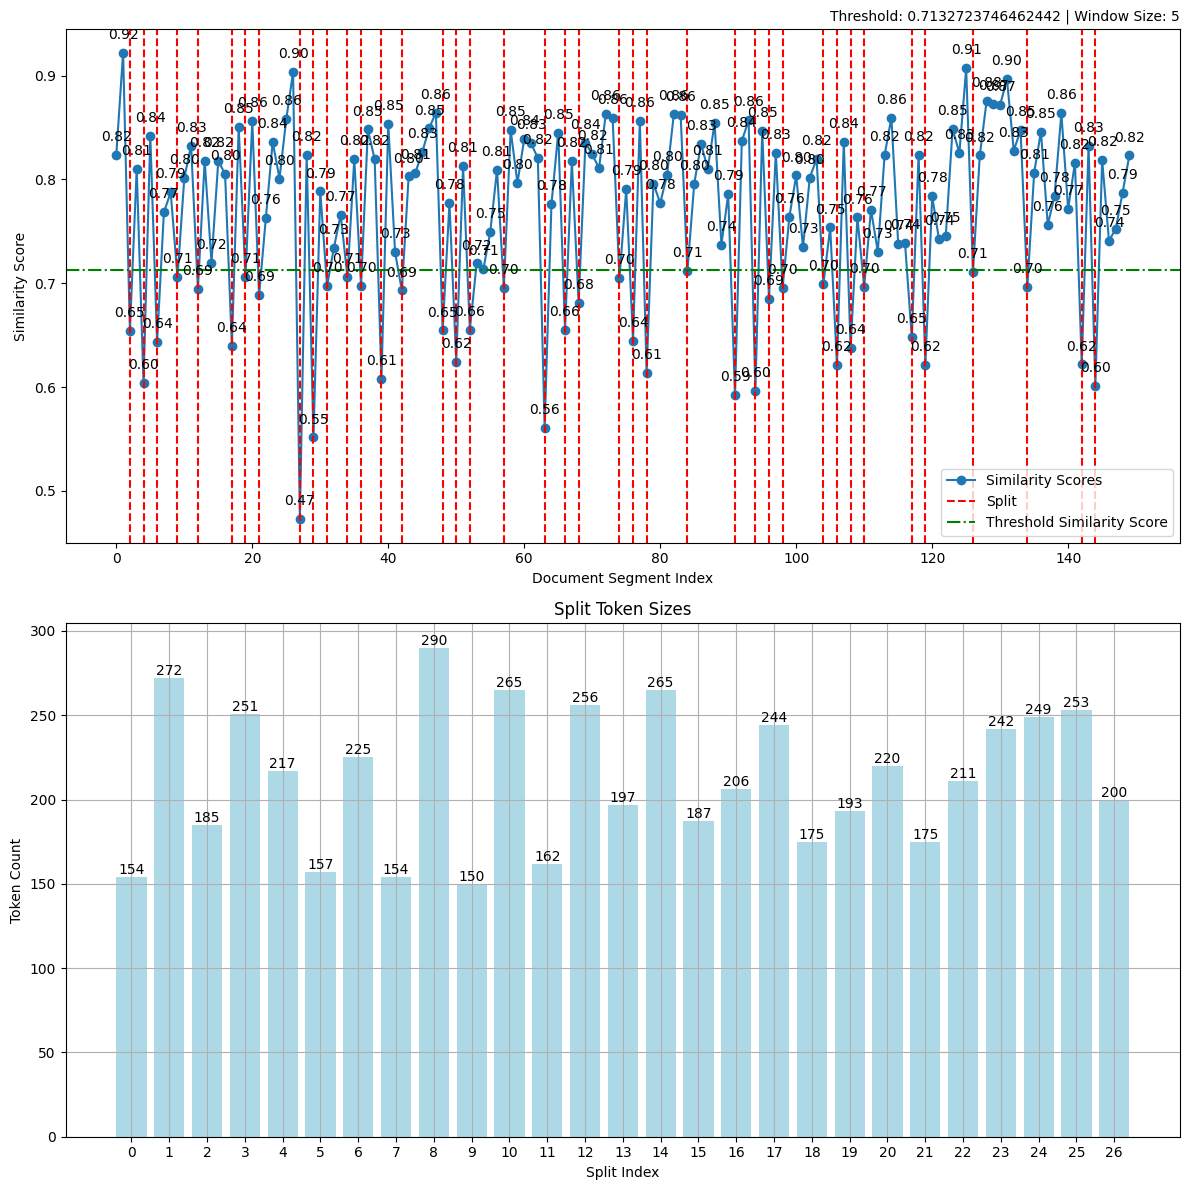

Splitting Statistics:
  - Total Documents: 151
  - Total Splits: 27
  - Splits by Threshold: 20
  - Splits by Max Chunk Size: 6
  - Last Split: 1
  - Minimum Token Size of Split: 150
  - Maximum Token Size of Split: 290
  - Similarity Split Ratio: 0.74


['La iniciativa legislativa se ejercerá por los órganos de gobierno de las Comunidades Autónomas en los términos establecidos por la Constitución y sus respectivos Estatutos de Autonomía. Asimismo, el Gobierno de la Nación podrá aprobar reales decretos-leyes y reales decretos legislativos en los términos previstos en la Constitución. Los respectivos órganos de gobierno de las Comunidades Autónomas podrán aprobar normas equivalentes a aquéllas en su ámbito territorial, de conformidad con lo establecido en la Constitución y en sus respectivos Estatutos de Autonomía.',
 '# Artículo 128. Potestad reglamentaria. 1. El ejercicio de la potestad reglamentaria corresponde al Gobierno de la Nación, a los órganos de Gobierno de las Comunidades Autónomas, de conformidad con lo establecido en sus respectivos Estatutos, y a los órganos de gobierno locales, de acuerdo con lo previsto en la Constitución, los Estatutos de Autonomía y la Ley 7/1985, de 2 de abril, reguladora de las Bases del Régimen Loc

In [2]:
chunks2 = get_pdf_chunks(["/home/peyzaguirre/notebooks/dev_chunking_system/abrir_pdf2.pdf"], "/home/peyzaguirre/notebooks/dev_chunking_system/output")
chunks2

In [3]:
chunks2[0]

'La iniciativa legislativa se ejercerá por los órganos de gobierno de las Comunidades Autónomas en los términos establecidos por la Constitución y sus respectivos Estatutos de Autonomía. Asimismo, el Gobierno de la Nación podrá aprobar reales decretos-leyes y reales decretos legislativos en los términos previstos en la Constitución. Los respectivos órganos de gobierno de las Comunidades Autónomas podrán aprobar normas equivalentes a aquéllas en su ámbito territorial, de conformidad con lo establecido en la Constitución y en sus respectivos Estatutos de Autonomía.'

In [20]:
len(chunks2)

27

In [ ]:
# ==============================
# 3. Datos de ejemplo
# ==============================

query = "¿Cuál es el régimen transitorio de aplicación de plazos a procedimientos administrativos?"
ground_truth = """ Según establece la Disposición Transitoria 3ª de la Ley 39/2015, el régimen transitorio es el siguiente: 
a) A los procedimientos ya iniciados antes de la entrada en vigor de la Ley no les será de aplicación la misma, rigiéndose por la normativa anterior.
b) Los procedimientos de revisión de oficio iniciados después de la entrada en vigor de la presente Ley se sustanciarán por las normas establecidas en ésta. 
c) Los actos y resoluciones dictados con posterioridad a la entrada en vigor de esta Ley se regirán, en cuanto al régimen de recursos, por las disposiciones de la misma. 
d) Los actos y resoluciones pendientes de ejecución a la entrada en vigor de esta Ley se regirán para su ejecución por la normativa vigente cuando se dictaron. 
e) A falta de previsiones expresas establecidas en las correspondientes disposiciones legales y reglamentarias, las cuestiones de Derecho transitorio que se susciten en materia de procedimiento administrativo se resolverán de acuerdo con los principios establecidos en los apartados anteriores.

"""


query2 = "¿cuales son las reglas que las administraciones publicas deben ajustarse para  garantizar la identidad y contenido de las copias electrónicas o en papel? "
ground_truth2 = """  Para garantizar la identidad y contenido de las copias electrónicas o en papel, y por tanto su carácter de copias auténticas, las Administraciones Públicas deberán ajustarse a lo previsto en el Esquema Nacional de Interoperabilidad, el Esquema Nacional de Seguridad y sus normas técnicas de desarrollo, así como a las siguientes reglas: 
a) Las copias electrónicas de un documento electrónico original o de una copia electrónica auténtica, con o sin cambio de formato, deberán incluir los metadatos que acrediten su condición de copia y que se visualicen al consultar el documento. 
b) Las copias electrónicas de documentos en soporte papel o en otro soporte no electrónico susceptible de digitalización, requerirán que el documento haya sido digitalizado y deberán incluir los metadatos que acrediten su condición de copia y que se visualicen al consultar el documento. 
c) Las copias en soporte papel de documentos electrónicos requerirán que en las mismas figure la condición de copia y contendrán un código generado electrónicamente u otro sistema de verificación, que permitirá contrastar la autenticidad de la copia mediante el acceso a los archivos electrónicos del órgano u Organismo público emisor. d) Las copias en soporte papel de documentos originales emitidos en dicho soporte se proporcionarán mediante una copia auténtica en papel del documento electrónico que se encuentre en poder de la Administración o bien mediante una puesta de manifiesto electrónica conteniendo copia auténtica del documento original. 
 """

query3 = " ¿En qué supuestos pueden las Administraciones practicar las notificaciones por medios no electrónicos aun cuando los interesados estén obligados a recibirlas por medios electrónicos? "

ground_truth3 = """  Las Administraciones podrán practicar las notificaciones por medios no electrónicos en los siguientes supuestos, tal y como recoge el artículo 41 de la Ley 39/2015: 
a) Cuando la notificación se realice con ocasión de la comparecencia espontánea del interesado o su representante en las oficinas de asistencia en materia de registro y solicite la comunicación o notificación personal en ese momento.
b) Cuando para asegurar la eficacia de la actuación administrativa resulte necesario practicar la notificación por entrega directa de un empleado público de la Administración notificante. En ningún caso se efectuarán por medios electrónicos las siguientes notificaciones: 
a) Aquellas en las que el acto a notificar vaya acompañado de elementos que no sean susceptibles de conversión en formato electrónico. 
b) Las que contengan medios de pago a favor de los obligados, tales como cheques.  """

In [26]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import tiktoken
from sklearn.metrics.pairwise import cosine_similarity

# ==============================
# 1. Cargar el modelo BGE-M3
# ==============================

device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "BAAI/bge-m3"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# ==============================
# 2. Función para obtener embeddings
# ==============================
def get_embedding(text, model, tokenizer, device="cpu"):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=8192)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # mover a GPU
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()  # traer a CPU
    return embeddings


# ==============================
# 4. Obtener embeddings de los chunks y la query
# ==============================
chunk_embeddings = [get_embedding(c, model, tokenizer, device=device) for c in chunks2]
gt_embedding = get_embedding(query, model, tokenizer, device=device)

# ==============================
# 5. Buscar el chunk más cercano
# ==============================
similarities = cosine_similarity([gt_embedding], chunk_embeddings)
best_idx = np.argmax(similarities)
best_chunk = chunks2[best_idx]

print(f"🔍 Chunk más cercano: {best_chunk}")




🔍 Chunk más cercano: Disposición transitoria tercera. Régimen transitorio de los procedimientos. a) A los procedimientos ya iniciados antes de la entrada en vigor de la Ley no les será de aplicación la misma, rigiéndose por la normativa anterior. b) Los procedimientos de revisión de o!cio iniciados después de la entrada en vigor de la presente Ley se sustanciarán por las normas establecidas en ésta. c) Los actos y resoluciones dictados con posterioridad a la entrada en vigor de esta Ley se regirán, en cuanto al régimen de recursos, por las disposiciones de la misma. d) Los actos y resoluciones pendientes de ejecución a la entrada en vigor de esta Ley se regirán para su ejecución por la normativa vigente cuando se dictaron. e) A falta de previsiones expresas establecidas en las correspondientes disposiciones legales y reglamentarias, las cues tiones de Derecho transitorio que se susciten en materia de procedimiento administrativo se resolverán de acuerdo con los principios establecidos 

In [25]:

# ==============================
# 6. Tokenizar con tiktoken
# ==============================
enc = tiktoken.encoding_for_model("gpt-4")
te = enc.encode(ground_truth)  # tokens relevantes
tr = enc.encode(best_chunk)    # tokens recuperados

# ==============================
# 7. Métricas IoU, Precision, Recall
# ==============================
def iou(te, tr):
    te_set, tr_set = set(te), set(tr)
    inter = te_set & tr_set
    union = te_set | tr_set
    return len(inter) / len(union) if union else 0

def precision(te, tr):
    te_set, tr_set = set(te), set(tr)
    inter = te_set & tr_set
    return len(inter) / len(tr_set) if tr_set else 0

def recall(te, tr):
    te_set, tr_set = set(te), set(tr)
    inter = te_set & tr_set
    return len(inter) / len(te_set) if te_set else 0

print("\n📊 Métricas sobre el chunk recuperado:")
print("IoU:", iou(te, tr))
print("Precision:", precision(te, tr))
print("Recall:", recall(te, tr))



📊 Métricas sobre el chunk recuperado:
IoU: 0.7435897435897436
Precision: 0.8923076923076924
Recall: 0.8169014084507042
